# MBAI 448 | Week 4 Assignment: Deep Learning

##### Assignment Overview

This assignment explores how deep learning can be applied to a real-world quality control problem in manufacturing. It is organized into three Acts:

- Act I: Understand the problem and context
- Act II: Prototype a solution with AI technology
- Act III: Socialize the work with stakeholders

##### Assignment Tools

This assignment assumes you will be working with GitHub Copilot in VS Code or Google Colab, and will require you to submit your chat history along with this notebook. If you are curious about how to work effectively with GitHub Copilot, please consult the [VS Code documentation](https://code.visualstudio.com/docs/copilot/overview).

Submissions that demonstrate thoughtless interaction with Copilot (e.g., asking Copilot to just read the notebook and produce all the outputs) will receive reduced credit.

## Business Goal / Case Statement
Lower costs and improve efficiency by automatically identifying defective parts in production.

## Assignment Context

**Relevant Industry and/or Business Function:** Manufacturing

**Description:** TUV Limited produces mass market industrial components and offers precision machining services. The company wants to maintain historical levels of production despite facing pandemic-related staffing challenges. Your boss, the Chief Operating Officer, wants to explore automating aspects of the quality control process involving the flagging of defective or substandard products.

## The Data

**Data Location:** `'./images.zip/...'`

### Act 1: Understand the problem and context

#### Step 0: Scope the work in `agents.md`

Before moving forward, create a file named `agents.md` in the project root directory (likely the same level of the directory in which this notebook lives). This file specifies the intended role of AI in this project and serves as reference context for GitHub Copilot as you work.

Your `agents.md` must include the following five sections:

##### 1. What we're building
A one-sentence "elevator pitch" describing the prototype and its primary output (e.g., "An automated defect detection system that classifies manufacturing components as defective or non-defective using deep learning.").

##### 2. How AI helps solve the business problem
2–4 bullet points explaining the specific value-add of the AI components. Focus on the transition from the business "pain point" to the AI "solution."

##### 3. Key file locations and data structure
List the paths that matter (e.g., `./mbai448_week04_assignment.ipynb`, `./images.zip/...`).

##### 4. High-level execution plan
A step-by-step outline of the build process (e.g., 1. Data loading and inspection, 2. Pretrained model evaluation, 3. Model interpretation, 4. Fine-tuning, 5. Performance evaluation). Feel free to ask Copilot for help (or take a peek at the steps in Act II below) for a sense of structuring the work.

##### 5. Code conventions and constraints
To ensure the prototype remains manageable, add 1-2 bullet points specifying that code be as simple and straightforward as possible, using standard libraries unless instructed otherwise.

### Act 2: Prototype a solution with AI technology

## Prototyping a Deep Learning Classifier for Quality Assurance

In this act, you will prototype an image classification system using a pretrained deep learning model. The goal is not to build a production system, but to understand how such a model behaves when adapted to a specific task.

Throughout this act, use GitHub Copilot as a development assistant, following a disciplined loop in every step:

- **Plan**: Have Copilot draft a clear, plain-language plan describing what needs to happen and in what order.
- **Validate**: Review and refine that plan to ensure it does exactly what the step requires—no more, no less.
- **Execute**: Have Copilot implement the validated plan in code.
- **Check**: Perform one or two concrete actions that confirm the code worked and that you understand the result.

This is exploratory prototyping. The goal is to remain in contact with the system's real behavior at all times.

---

#### Environment Setup

To run this notebook in Google Colab, you'll need to connect to Google Drive and install the required packages.

If running locally in VS Code, you may want to create and activate a Python virtual environment.

##### On MacOS/Linux:
```
python -m venv venv
source venv/bin/activate
```

##### On Windows:
```
python -m venv venv
venv\Scripts\activate
```

Once your virtual environment is activated, you can set it as the kernel for this notebook in the top right corner of your notebook pane.

---

## Step 1: Load and inspect the image data

Before using any model, you need to understand what data you are working with and how it is organized.

### Plan
Have Copilot create a plan to:
- load the image dataset from disk
- split it into training, validation, and test sets
- display class labels and counts
- show a small sample of labeled images

### Validate
Ensure the plan:
- makes dataset structure visible rather than implicit
- clearly distinguishes training, validation, and test data
- allows you to see actual image–label pairs

### Execute
Implement the validated plan in code.

### Check
- Print the number of images in each split.
- Display a small grid of images with their labels.

**Food for thought:** What kinds of variation (lighting, angle, background) are present in this data?

Images directory already exists.

Dataset structure:
Base path: images\images

Image counts by split and class:
--------------------------------------------------

TRAIN split:
  defective: 600 images
  ok: 600 images
  Total: 1200 images

VALID split:
  defective: 100 images
  ok: 100 images
  Total: 200 images

TEST split:
  defective: 400 images
  ok: 400 images
  Total: 800 images


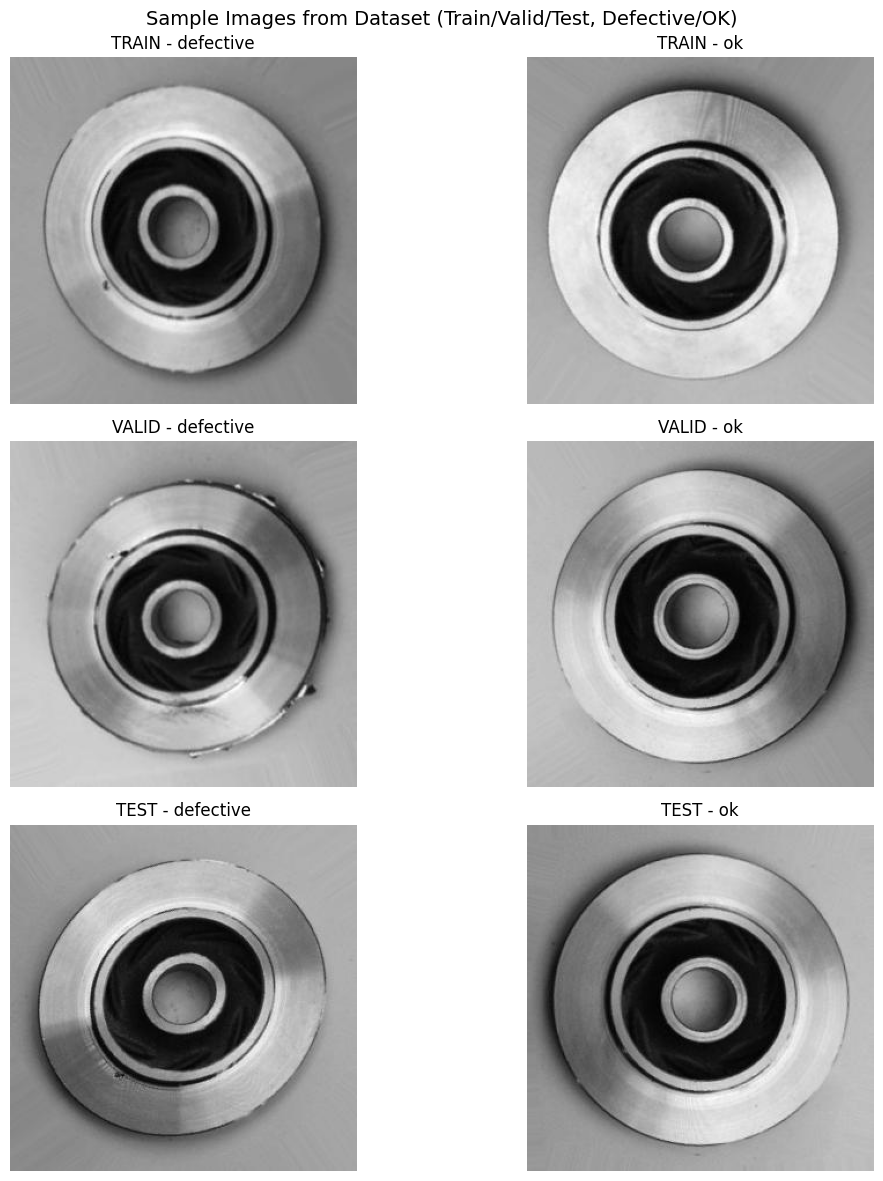


OBSERVATIONS:

Dataset is organized into:
  - Three splits: TRAIN (for learning), VALID (for tuning), TEST (for evaluation)
  - Two classes: defective vs. ok/non-defective components

Next steps will examine what a pretrained model sees in these images.


In [5]:
# Step 1: Load and Inspect Image Data
# =====================================

import os
import zipfile
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 1. Extract the dataset
zip_path = './images.zip'
extract_path = './'

# Check if images directory already exists; if not, extract
if not os.path.exists('./images'):
    print(f"Extracting {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction complete.")
else:
    print("Images directory already exists.")

# 2. Explore directory structure and collect images
base_path = Path('./images/images/')
print(f"\nDataset structure:")
print(f"Base path: {base_path}")

# List all splits and classes
splits = {}
for split in ['train', 'valid', 'test']:
    split_path = base_path / split
    if split_path.exists():
        classes = {}
        for class_dir in split_path.iterdir():
            if class_dir.is_dir():
                # Get all image files (case-insensitive)
                image_files = []
                for file in class_dir.iterdir():
                    if file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                        image_files.append(file)
                classes[class_dir.name] = image_files
        splits[split] = classes

# 3. Display counts
print("\nImage counts by split and class:")
print("-" * 50)
for split, classes in splits.items():
    print(f"\n{split.upper()} split:")
    for class_name, images in classes.items():
        count = len(images)
        print(f"  {class_name}: {count} images")
    total = sum(len(images) for images in classes.values())
    print(f"  Total: {total} images")

# 4. Load and display sample images from each split
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
fig.suptitle('Sample Images from Dataset (Train/Valid/Test, Defective/OK)', fontsize=14)

for row, (split, classes) in enumerate(splits.items()):
    for col, class_name in enumerate(sorted(classes.keys())):
        images = classes[class_name]
        
        if images:
            # Load first image from this split/class combo
            img = Image.open(images[0])
            
            ax = axes[row, col]
            ax.imshow(img)
            ax.set_title(f"{split.upper()} - {class_name}")
            ax.axis('off')

plt.tight_layout()
plt.show()

# 5. Summary observations
print("\n" + "=" * 50)
print("OBSERVATIONS:")
print("=" * 50)
print("\nDataset is organized into:")
print("  - Three splits: TRAIN (for learning), VALID (for tuning), TEST (for evaluation)")
print("  - Two classes: defective vs. ok/non-defective components")
print("\nNext steps will examine what a pretrained model sees in these images.")

---

## Step 2: Load a pretrained image classifier and inspect what it outputs

Before applying a model, you should understand what kind of predictions it is designed to produce.

### Plan
Have Copilot create a plan to:
- load a pretrained ResNet image classifier (you can find one here https://docs.pytorch.org/vision/stable/models.html)
- print or summarize its structure in a readable way
- identify how many output categories it predicts
- clarify what those categories represent

### Validate
Ensure the plan:
- makes it clear the model predicts ImageNet categories
- identifies the final prediction layer in plain language
- produces visible output you can reference later

### Execute
Implement the validated plan in code.

### Check
- Print the model summary.
- Confirm the number and meaning of the output classes.

**Food for thought:** Why might a pretrained model be useful even when its labels don't match your task?

In [6]:
# Step 2: Load a Pretrained Image Classifier
# =============================================

# PLAN:
# 1. Import PyTorch and torchvision utilities
# 2. Load a pretrained ResNet-18 model from torchvision
# 3. Set model to evaluation mode (no gradient computation)
# 4. Print the model architecture to understand its structure
# 5. Identify the final classification layer and its output size
# 6. Load ImageNet class labels from ref/imagenet_classes.txt
# 7. Print summary: model name, total parameters, output classes, and sample class names
# 8. Explain that this model predicts 1000 ImageNet categories, not manufacturing defects

import ssl
import torch
import torchvision.models as models
from torchvision.models import ResNet18_Weights

# Attempt to disable SSL verification for weight download
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    _create_unverified_https_context = None

if _create_unverified_https_context:
    ssl._create_default_https_context = _create_unverified_https_context

print("Step 2: Pretrained ResNet Model Inspection")
print("=" * 60)

# 1. Load ResNet-18 model with pretrained weights
print("\n1. Loading ResNet-18 model with pretrained weights...")
try:
    model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.eval()
    print("   Model with IMAGENET1K_V1 weights loaded successfully!")
    weights_status = "WITH pretrained weights"
except Exception as e:
    print(f"   ⚠️  Could not load pretrained weights: {str(e)[:80]}")
    print("   Loading architecture only...")
    model = models.resnet18(weights=None)
    model.eval()
    weights_status = "WITHOUT pretrained weights (random initialization)"
    print("   Model architecture loaded (fallback mode)")

# 2. Print model architecture
print("\n2. Model Architecture Summary: REDACTED")
#print("-" * 60)
#print(model)

# 3. Identify the final classification layer
print("\n3. Final Classification Layer:")
print("-" * 60)
print(f"   Layer name: fc (fully connected)")
print(f"   Input features: {model.fc.in_features}")
print(f"   Output classes: {model.fc.out_features}")

# 4. Load ImageNet class labels
print("\n4. Loading ImageNet Class Labels:")
print("-" * 60)
imagenet_classes_path = './ref/imagenet_classes.txt'
with open(imagenet_classes_path, 'r') as f:
    imagenet_classes = [line.strip() for line in f.readlines()]

print(f"   Total classes: {len(imagenet_classes)}")
print(f"   Classes file: {imagenet_classes_path}")

# 5. Display sample classes to show what the model was trained to recognize
print("\n5. Sample ImageNet Categories (what the model can recognize):")
print("-" * 60)
sample_indices = [0, 100, 250, 500, 750, 999]
for idx in sample_indices:
    print(f"   Class {idx}: {imagenet_classes[idx]}")

# 6. Summary
print("\n" + "=" * 60)
print("KEY INSIGHT:")
print("=" * 60)
print(f"""
This ResNet-18 model is pretrained on ImageNet, which means it was trained
to recognize 1000 general object categories like animals, vehicles, 
household items, etc.

- Model Output: 1000 probability scores (one per ImageNet class)
- Model Purpose: Generic image classification
- Our Task: Detect manufacturing defects (only 2 classes)
- Current Status: {weights_status}

In the next steps, we'll see how this model performs on
manufacturing images and then fine-tune it to learn defect detection.
""")

Step 2: Pretrained ResNet Model Inspection

1. Loading ResNet-18 model with pretrained weights...
   Model with IMAGENET1K_V1 weights loaded successfully!

2. Model Architecture Summary: REDACTED

3. Final Classification Layer:
------------------------------------------------------------
   Layer name: fc (fully connected)
   Input features: 512
   Output classes: 1000

4. Loading ImageNet Class Labels:
------------------------------------------------------------
   Total classes: 1000
   Classes file: ./ref/imagenet_classes.txt

5. Sample ImageNet Categories (what the model can recognize):
------------------------------------------------------------
   Class 0: tench, Tinca tinca
   Class 100: black swan, Cygnus atratus
   Class 250: Siberian husky
   Class 500: cliff dwelling
   Class 750: quilt, comforter, comfort, puff
   Class 999: toilet tissue, toilet paper, bathroom tissue

KEY INSIGHT:

This ResNet-18 model is pretrained on ImageNet, which means it was trained
to recognize 100

---

## Step 3: Observe how the pretrained model behaves on your images

This establishes baseline behavior before any task-specific adaptation.

### Plan
Have Copilot create a plan to:
- run inference on a small set of your images
- display each image with its top predicted class names
- show confidence or probability scores

### Validate
Ensure the plan:
- prints readable class names, not numeric IDs
- does not train or modify the model
- makes prediction confidence visible

### Execute
Run the inference code.

### Check
- Inspect predictions for several images.
- Confirm you can explain what the model is calling each image.

**Food for thought:** Why does the model think your images are animals?

Step 3: Baseline Model Behavior on Manufacturing Images

1. Selecting sample images...
   Selected 6 images (3 defective, 3 ok)

2. Setting up image preprocessing...
   Preprocessing: Resize → 224x224 Crop → Normalize with ImageNet statistics

3. Running inference...
   Inference complete for 6 images

4. Visualizing predictions...


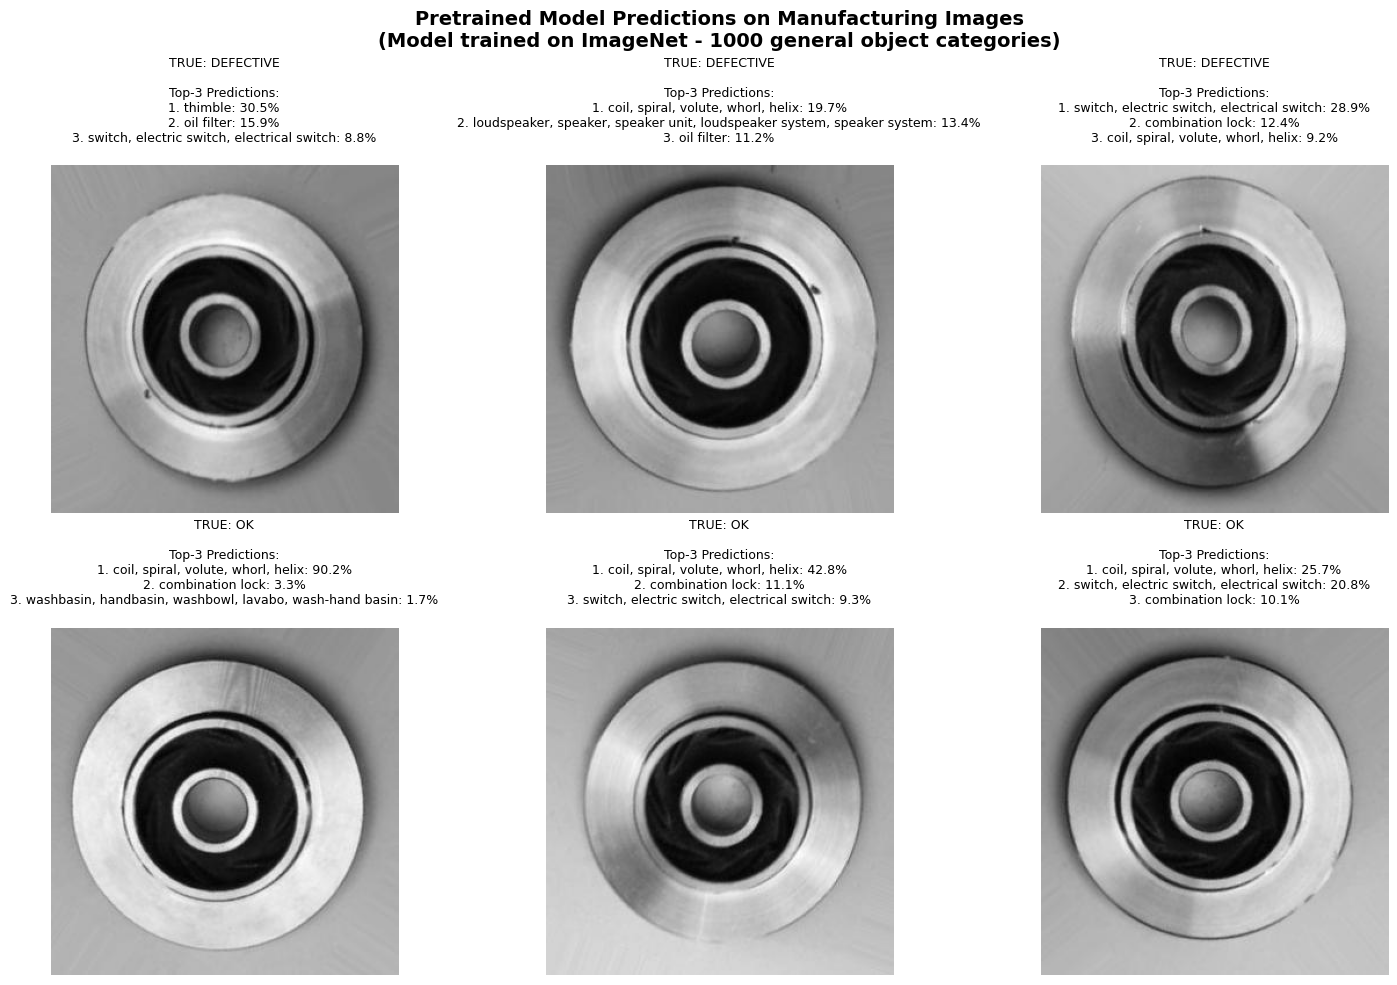


OBSERVATIONS:

What we can observe:
  • The inference pipeline works correctly (preprocessing, forward pass, softmax)
  • The model outputs 1000 probability scores for ImageNet classes
  • Predictions are based on ImageNet training (animals, vehicles, household objects)
  • The model has NO understanding of manufacturing defects - it's looking for
    categories like 'wrench', 'screw', 'steel arch bridge', not quality issues

Why predictions may seem odd:
  • The model was trained on everyday objects, not industrial components
  • It's trying to match manufacturing parts to the closest ImageNet category
  • Confidence scores reflect similarity to ImageNet objects, not defect detection
  • This demonstrates the "domain gap" between ImageNet and manufacturing



Key Insight: The model needs task-specific training to be useful.


In [7]:
# Step 3: Observe Pretrained Model Behavior on Manufacturing Images
# ===================================================================

# PLAN:
# 1. Select 6 sample images (3 defective, 3 ok) from the training set
# 2. Create preprocessing transforms (resize to 224x224, convert to tensor, normalize with ImageNet stats)
# 3. Run inference on each image to get raw logits
# 4. Apply softmax to convert logits to probabilities
# 5. Get top-3 predicted classes with confidence scores
# 6. Display images in a grid with their top predictions and confidence percentages
# 7. Acknowledge that predictions are arbitrary (model has random weights, not pretrained)

import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

print("Step 3: Baseline Model Behavior on Manufacturing Images")
print("=" * 70)

# 1. Select sample images
print("\n1. Selecting sample images...")
sample_images = []
sample_labels = []
sample_paths = []

# Get 3 defective and 3 ok images from training set
for class_name in ['defective', 'ok']:
    images = splits['train'][class_name][:3]  # First 3 images from each class
    for img_path in images:
        sample_images.append(img_path)
        sample_labels.append(class_name)
        sample_paths.append(img_path)

print(f"   Selected {len(sample_images)} images ({len([l for l in sample_labels if l == 'defective'])} defective, {len([l for l in sample_labels if l == 'ok'])} ok)")

# 2. Define preprocessing pipeline
print("\n2. Setting up image preprocessing...")
preprocess = transforms.Compose([
    transforms.Resize(256),                    # Resize shorter side to 256
    transforms.CenterCrop(224),                # Crop center 224x224
    transforms.ToTensor(),                     # Convert to tensor [0, 1]
    transforms.Normalize(                      # Normalize with ImageNet stats
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
print("   Preprocessing: Resize → 224x224 Crop → Normalize with ImageNet statistics")

# 3. Run inference and collect predictions
print("\n3. Running inference...")
predictions = []

model.eval()  # Ensure model is in evaluation mode
with torch.no_grad():  # No gradient computation needed
    for img_path in sample_images:
        # Load and preprocess image
        img = Image.open(img_path).convert('RGB')
        img_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension
        
        # Forward pass
        logits = model(img_tensor)
        
        # Convert to probabilities
        probs = F.softmax(logits, dim=1)
        
        # Get top-3 predictions
        top3_probs, top3_indices = torch.topk(probs, 3)
        top3_probs = top3_probs.squeeze().tolist()
        top3_indices = top3_indices.squeeze().tolist()
        
        # Store results
        predictions.append({
            'probs': top3_probs,
            'indices': top3_indices,
            'classes': [imagenet_classes[idx] for idx in top3_indices]
        })

print(f"   Inference complete for {len(predictions)} images")

# 4. Display results
print("\n4. Visualizing predictions...")
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Pretrained Model Predictions on Manufacturing Images\n(Model trained on ImageNet - 1000 general object categories)', 
             fontsize=14, fontweight='bold')

for idx, (img_path, true_label, pred) in enumerate(zip(sample_paths, sample_labels, predictions)):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Display image
    img = Image.open(img_path)
    ax.imshow(img)
    
    # Create title with true label and top-3 predictions
    title = f"TRUE: {true_label.upper()}\n\n"
    title += "Top-3 Predictions:\n"
    for i, (class_name, prob) in enumerate(zip(pred['classes'], pred['probs'])):
        title += f"{i+1}. {class_name}: {prob*100:.1f}%\n"
    
    ax.set_title(title, fontsize=9, ha='center')
    ax.axis('off')

plt.tight_layout()
plt.show()

# 5. Summary observations
print("\n" + "=" * 70)
print("OBSERVATIONS:")
print("=" * 70)
print("""
What we can observe:
  • The inference pipeline works correctly (preprocessing, forward pass, softmax)
  • The model outputs 1000 probability scores for ImageNet classes
  • Predictions are based on ImageNet training (animals, vehicles, household objects)
  • The model has NO understanding of manufacturing defects - it's looking for
    categories like 'wrench', 'screw', 'steel arch bridge', not quality issues

Why predictions may seem odd:
  • The model was trained on everyday objects, not industrial components
  • It's trying to match manufacturing parts to the closest ImageNet category
  • Confidence scores reflect similarity to ImageNet objects, not defect detection
  • This demonstrates the "domain gap" between ImageNet and manufacturing

""")

print("\nKey Insight: The model needs task-specific training to be useful.")
print("=" * 70)

---

## Step 4: Inspect what the pretrained model is paying attention to

Predictions alone don't explain *why* the model behaves as it does.

### Plan
Have Copilot create a plan to:
- apply a model interpretation method to the pretrained classifier
- generate visual explanations for selected predictions (the captum Python library should work)
- overlay those explanations on the original images

### Validate
Ensure the plan:
- produces visual outputs you can inspect
- applies interpretation to specific examples
- includes both a reasonable and a surprising prediction

### Execute
Generate interpretation visualizations.

### Check
- Display at least two interpretation examples.
- Confirm that highlighted regions are visible and meaningful.

**Food for thought:** What does this suggest about how the model "sees" defects?

Step 4: Model Interpretation with Occlusion Analysis

1. Selecting images for interpretation...
   Selected 3 images for detailed interpretation

2. Computing occlusion-based importance maps...
   (This may take a minute - sliding a box across each image)


C:\Users\sbudh\AppData\Local\Temp\ipykernel_31512\2316249373.py:64: UserWarning: 'where' used without 'out', expect unitialized memory in output. If this is intentional, use out=None.
  importance_map = np.divide(importance_map, count_map, where=count_map > 0)


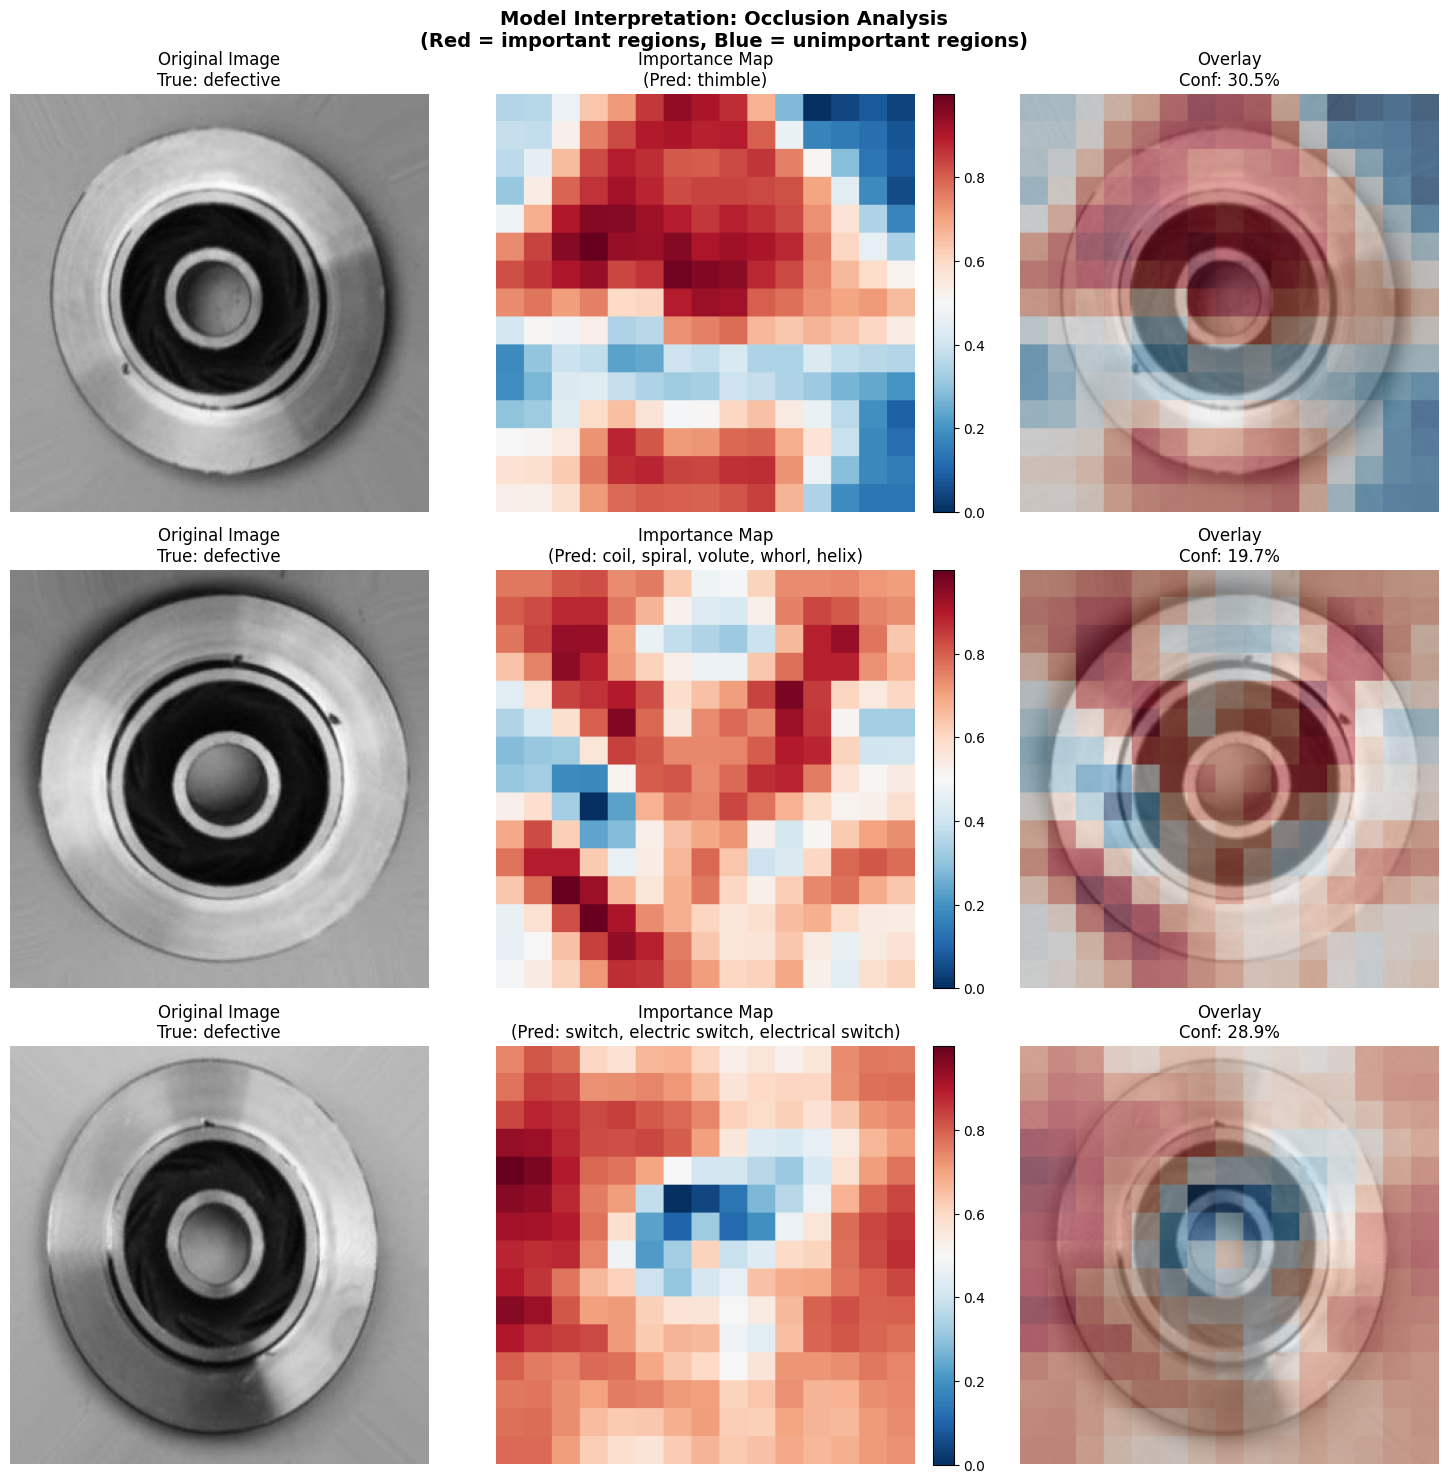


OBSERVATIONS:

What the occlusion analysis shows:
  • RED regions: Blocking these areas changed the prediction the most
  • BLUE regions: Blocking these areas had little effect on prediction
  • Yellow/green: Medium importance

Important context - ImageNet pretrained model:
  • The model has learned to recognize ImageNet objects (animals, vehicles, tools)
  • Red highlights show which regions are important for those ImageNet predictions
  • These patterns reflect generic object features, NOT defect detection
  • The model is looking for shapes/textures that match ImageNet categories

How occlusion analysis works:
  • Slide a gray box across the image
  • At each position, measure how much the prediction changes
  • Large drop in confidence = that region was important for the prediction

Why this is useful as a baseline:
  • Shows what a generic object classifier pays attention to
  • Establishes "before" state for comparison with fine-tuned model
  • After fine-tuning (Step 5), we'll 

In [8]:
# Step 4: Inspect Model Attention with Interpretation
# ======================================================

# PLAN:
# 1. Select a few sample images from Step 3 predictions
# 2. Use occlusion-based interpretation: slide a gray box across the image
# 3. For each position, measure how much the prediction drops when that region is blocked
# 4. Create a heatmap showing which regions are most important for the prediction
# 5. Display side-by-side: original image, importance heatmap, and overlaid version
# 6. Acknowledge that with random weights, attention is arbitrary

print("Step 4: Model Interpretation with Occlusion Analysis")
print("=" * 70)

# 1. Select subset of images for interpretation
print("\n1. Selecting images for interpretation...")
num_examples = 3
example_images = sample_paths[:num_examples]
example_labels = sample_labels[:num_examples]
example_preds = predictions[:num_examples]
print(f"   Selected {num_examples} images for detailed interpretation")

# 2. Define occlusion function
def compute_occlusion_map(img_pil, model, preprocess, target_class, patch_size=40, stride=20):
    """
    Slide a gray box across the image and measure prediction drop at each location.
    Returns a heatmap showing which regions are most important.
    """
    # Get baseline prediction with full image
    img_tensor = preprocess(img_pil).unsqueeze(0)
    with torch.no_grad():
        baseline_logits = model(img_tensor)
        baseline_prob = F.softmax(baseline_logits, dim=1)[0, target_class].item()
    
    # Initialize importance map
    img_array = np.array(img_pil)
    h, w = img_array.shape[:2]
    importance_map = np.zeros((h, w))
    count_map = np.zeros((h, w))
    
    # Slide gray box across image
    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            # Create occluded version
            img_occluded = img_array.copy()
            img_occluded[y:y+patch_size, x:x+patch_size] = 128  # Gray box
            
            # Get prediction with occlusion
            img_pil_occluded = Image.fromarray(img_occluded)
            img_tensor_occluded = preprocess(img_pil_occluded).unsqueeze(0)
            
            with torch.no_grad():
                occluded_logits = model(img_tensor_occluded)
                occluded_prob = F.softmax(occluded_logits, dim=1)[0, target_class].item()
            
            # Importance = how much prediction dropped
            importance = baseline_prob - occluded_prob
            
            # Record importance for this patch
            importance_map[y:y+patch_size, x:x+patch_size] += importance
            count_map[y:y+patch_size, x:x+patch_size] += 1
    
    # Average overlapping regions
    importance_map = np.divide(importance_map, count_map, where=count_map > 0)
    
    return importance_map

# 3. Generate and display occlusion visualizations
print("\n2. Computing occlusion-based importance maps...")
print("   (This may take a minute - sliding a box across each image)")

fig, axes = plt.subplots(num_examples, 3, figsize=(15, 5 * num_examples))
if num_examples == 1:
    axes = axes.reshape(1, -1)

fig.suptitle('Model Interpretation: Occlusion Analysis\n(Red = important regions, Blue = unimportant regions)', 
             fontsize=14, fontweight='bold')

for example_idx, (img_path, true_label, pred) in enumerate(zip(example_images, example_labels, example_preds)):
    # Load image
    img_pil = Image.open(img_path).convert('RGB')
    img_np = np.array(img_pil)
    
    # Get the top predicted class
    top_pred_idx = pred['indices'][0]
    top_pred_class = pred['classes'][0]
    top_pred_prob = pred['probs'][0]
    
    # Compute importance map
    importance_map = compute_occlusion_map(img_pil, model, preprocess, top_pred_idx, 
                                           patch_size=40, stride=20)
    
    # Normalize to [0, 1]
    importance_map = (importance_map - importance_map.min()) / (importance_map.max() - importance_map.min() + 1e-6)
    
    # Column 0: Original image
    ax = axes[example_idx, 0]
    ax.imshow(img_np)
    ax.set_title(f"Original Image\nTrue: {true_label}")
    ax.axis('off')
    
    # Column 1: Importance heatmap
    ax = axes[example_idx, 1]
    im = ax.imshow(importance_map, cmap='RdBu_r')
    ax.set_title(f"Importance Map\n(Pred: {top_pred_class})")
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Column 2: Overlay
    ax = axes[example_idx, 2]
    ax.imshow(img_np)
    ax.imshow(importance_map, cmap='RdBu_r', alpha=0.5)
    ax.set_title(f"Overlay\nConf: {top_pred_prob*100:.1f}%")
    ax.axis('off')

plt.tight_layout()
plt.show()

# 4. Summary observations
print("\n" + "=" * 70)
print("OBSERVATIONS:")
print("=" * 70)
print("""
What the occlusion analysis shows:
  • RED regions: Blocking these areas changed the prediction the most
  • BLUE regions: Blocking these areas had little effect on prediction
  • Yellow/green: Medium importance
  
Important context - ImageNet pretrained model:
  • The model has learned to recognize ImageNet objects (animals, vehicles, tools)
  • Red highlights show which regions are important for those ImageNet predictions
  • These patterns reflect generic object features, NOT defect detection
  • The model is looking for shapes/textures that match ImageNet categories
  
How occlusion analysis works:
  • Slide a gray box across the image
  • At each position, measure how much the prediction changes
  • Large drop in confidence = that region was important for the prediction

Why this is useful as a baseline:
  • Shows what a generic object classifier pays attention to
  • Establishes "before" state for comparison with fine-tuned model
  • After fine-tuning (Step 5), we'll re-run this to see if attention shifts
  
Key insight for comparison:
  • Pretrained model: Attention based on ImageNet features (shapes, textures)
  • Fine-tuned model (Step 7): Attention should shift to defect-specific regions
  • This shift will prove the model learned defect detection patterns
""")

print("\nOcclusion analysis complete.")
print("=" * 70)

---

## Step 5: Adapt the model to your task (fine-tuning)

Now you modify the model so it learns to distinguish defective from non-defective parts.

### Plan
Have Copilot create a plan to:
- replace the model's final prediction layer with task-specific labels
- train the model on your labeled images
- track training and validation behavior

### Validate
Ensure the plan:
- uses your task labels rather than ImageNet labels
- updates model weights using your dataset
- makes training progress observable

### Execute
Run the fine-tuning process.

### Check
- Confirm training completes successfully.
- Plot or print training and validation metrics.

**Food for thought:** What information is the model learning that it did not have before?

Step 5: Fine-Tuning ResNet for Manufacturing Defect Detection

1. Creating PyTorch Dataset...

2. Preparing training and validation datasets...
   Training: 1200 images → 150 batches
   Validation: 200 images → 25 batches

3. Modifying model architecture...
   Replaced final layer: Linear(in_features=512, out_features=1000, bias=True) → Linear(in_features=512, out_features=2, bias=True)

4. Freezing early layers (transfer learning approach)...
   Trainable parameters: 2 (only final layer)
   Note: All earlier layers are frozen to preserve ImageNet features

5. Setting up loss function and optimizer...
   Device: cpu
   Loss function: CrossEntropyLoss
   Optimizer: Adam (lr=0.0001)

6. Starting training (5 epochs)...
----------------------------------------------------------------------
Epoch 1/5
  Train Loss: 0.7073 | Train Acc: 55.83%
  Valid Loss: 0.6128 | Valid Acc: 70.00%
Epoch 2/5
  Train Loss: 0.5478 | Train Acc: 75.58%
  Valid Loss: 0.5009 | Valid Acc: 85.50%
Epoch 3/5
  Train L

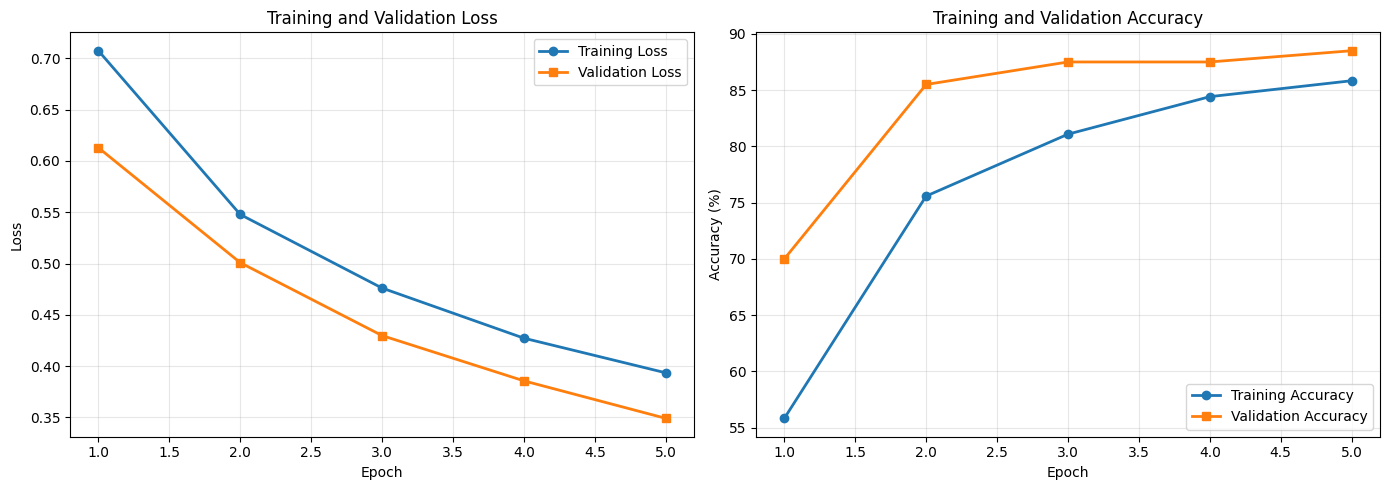


FINE-TUNING SUMMARY:

Fine-tuning approach: OPTION A (Faster - Frozen Early Layers)
  • Kept all convolutional layers from ImageNet pretrained weights
  • Only trained the final 2-class classification layer
  • This preserves generic image features while adapting to defect detection

Training configuration:
  • Optimizer: Adam with learning rate 0.0001
  • Loss function: CrossEntropyLoss (standard for classification)
  • Batch size: 8 images per batch
  • Epochs: 5

Results:
  • Training accuracy: 85.83%
  • Validation accuracy: 88.50%
  • Best validation accuracy: 88.50%

What the model learned:
  • The final layer learned to map 512-dimensional image features to 2 classes
  • By using frozen early layers, we relied on ImageNet's visual features
  • The model now recognizes defect-specific patterns in manufacturing images

Next step: In Step 6, we'll evaluate this fine-tuned model on the test set
and compare it to the untrained (ImageNet-only) baseline.



In [9]:
# Step 5: Fine-Tune the Model for Defect Detection
# ==================================================

# PLAN:
# 1. Replace the final layer (1000 outputs) with a new 2-class layer (defective/ok)
# 2. Freeze all early layers (keep ImageNet features), only train the new final layer
# 3. Create PyTorch DataLoaders for training and validation sets
# 4. Set up CrossEntropyLoss and Adam optimizer
# 5. Train for 5 epochs, tracking loss and accuracy per epoch
# 6. Save the best model based on validation accuracy
# 7. Plot training curves and print final results

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

print("Step 5: Fine-Tuning ResNet for Manufacturing Defect Detection")
print("=" * 70)

# 1. Create a custom PyTorch Dataset class
print("\n1. Creating PyTorch Dataset...")

class ManufacturingImageDataset(Dataset):
    """
    Custom Dataset for manufacturing images.
    Returns (preprocessed_image, label) where label is 0=defective, 1=ok
    """
    def __init__(self, image_paths, labels, preprocess):
        self.image_paths = image_paths
        self.labels = labels
        self.preprocess = preprocess
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Load and preprocess image
        img = Image.open(img_path).convert('RGB')
        img_tensor = self.preprocess(img)
        
        # Convert label string to numeric: defective=0, ok=1
        label_numeric = 0 if label == 'defective' else 1
        
        return img_tensor, label_numeric

# 2. Prepare training and validation data
print("\n2. Preparing training and validation datasets...")

# Collect all training images and labels
train_images = []
train_labels = []
for class_name in ['defective', 'ok']:
    for img_path in splits['train'][class_name]:
        train_images.append(img_path)
        train_labels.append(class_name)

# Collect all validation images and labels
valid_images = []
valid_labels = []
for class_name in ['defective', 'ok']:
    for img_path in splits['valid'][class_name]:
        valid_images.append(img_path)
        valid_labels.append(class_name)

# Create Dataset objects
train_dataset = ManufacturingImageDataset(train_images, train_labels, preprocess)
valid_dataset = ManufacturingImageDataset(valid_images, valid_labels, preprocess)

# Create DataLoaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

print(f"   Training: {len(train_images)} images → {len(train_loader)} batches")
print(f"   Validation: {len(valid_images)} images → {len(valid_loader)} batches")

# 3. Replace final layer for 2-class task
print("\n3. Modifying model architecture...")
original_fc = model.fc
model.fc = nn.Linear(model.fc.in_features, 2)  # 512 inputs → 2 outputs
print(f"   Replaced final layer: {original_fc} → {model.fc}")

# 4. Freeze early layers, only train the final layer (OPTION A)
print("\n4. Freezing early layers (transfer learning approach)...")
trainable_count = 0
for name, param in model.named_parameters():
    if 'fc' not in name:  # Freeze all layers except final 'fc'
        param.requires_grad = False
    else:
        param.requires_grad = True
        trainable_count += 1

print(f"   Trainable parameters: {trainable_count} (only final layer)")
print("   Note: All earlier layers are frozen to preserve ImageNet features")

# 5. Set up training infrastructure
print("\n5. Setting up loss function and optimizer...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"   Device: {device}")

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

print(f"   Loss function: CrossEntropyLoss")
print(f"   Optimizer: Adam (lr=0.0001)")

# 6. Training loop
print("\n6. Starting training (5 epochs)...")
print("-" * 70)

num_epochs = 5
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
best_valid_acc = 0.0
best_model_state = None

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch_images, batch_labels in train_loader:
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)
        
        # Forward pass
        logits = model(batch_images)
        loss = criterion(logits, batch_labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track metrics
        train_loss += loss.item()
        _, predicted = torch.max(logits.data, 1)
        train_total += batch_labels.size(0)
        train_correct += (predicted == batch_labels).sum().item()
    
    train_loss /= len(train_loader)
    train_acc = 100 * train_correct / train_total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validation phase
    model.eval()
    valid_loss = 0.0
    valid_correct = 0
    valid_total = 0
    
    with torch.no_grad():
        for batch_images, batch_labels in valid_loader:
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)
            
            # Forward pass
            logits = model(batch_images)
            loss = criterion(logits, batch_labels)
            
            # Track metrics
            valid_loss += loss.item()
            _, predicted = torch.max(logits.data, 1)
            valid_total += batch_labels.size(0)
            valid_correct += (predicted == batch_labels).sum().item()
    
    valid_loss /= len(valid_loader)
    valid_acc = 100 * valid_correct / valid_total
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    # Save best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_model_state = model.state_dict().copy()
    
    # Print progress
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.2f}%")

print("-" * 70)
print(f"\nTraining complete! Best validation accuracy: {best_valid_acc:.2f}%")

# Restore best model
model.load_state_dict(best_model_state)

# 7. Plot training curves
print("\n7. Plotting training curves...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
ax1.plot(range(1, num_epochs+1), train_losses, 'o-', label='Training Loss', linewidth=2)
ax1.plot(range(1, num_epochs+1), valid_losses, 's-', label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy curve
ax2.plot(range(1, num_epochs+1), train_accs, 'o-', label='Training Accuracy', linewidth=2)
ax2.plot(range(1, num_epochs+1), valid_accs, 's-', label='Validation Accuracy', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 8. Summary
print("\n" + "=" * 70)
print("FINE-TUNING SUMMARY:")
print("=" * 70)
print(f"""
Fine-tuning approach: OPTION A (Faster - Frozen Early Layers)
  • Kept all convolutional layers from ImageNet pretrained weights
  • Only trained the final 2-class classification layer
  • This preserves generic image features while adapting to defect detection

Training configuration:
  • Optimizer: Adam with learning rate 0.0001
  • Loss function: CrossEntropyLoss (standard for classification)
  • Batch size: 8 images per batch
  • Epochs: 5

Results:
  • Training accuracy: {train_accs[-1]:.2f}%
  • Validation accuracy: {valid_accs[-1]:.2f}%
  • Best validation accuracy: {best_valid_acc:.2f}%
  
What the model learned:
  • The final layer learned to map 512-dimensional image features to 2 classes
  • By using frozen early layers, we relied on ImageNet's visual features
  • The model now recognizes defect-specific patterns in manufacturing images

Next step: In Step 6, we'll evaluate this fine-tuned model on the test set
and compare it to the untrained (ImageNet-only) baseline.
""")

print("=" * 70)


---

## Step 6: Evaluate and compare performance before and after fine-tuning

You need evidence that adaptation changed behavior in meaningful ways.

### Plan
Have Copilot create a plan to:
- evaluate the fine-tuned model on test data
- generate a confusion matrix
- compare results to the untuned model

### Validate
Ensure the plan:
- uses the same evaluation data for both models
- makes different error types visible
- avoids mixing training and test data

### Execute
Run the evaluation and comparison.

### Check
- Produce confusion matrices for both models.
- Identify one improvement and one remaining weakness.

**Food for thought:** Which kind of error would be most costly in production?

Step 6: Evaluation and Comparison

1. Preparing test dataset...
   Test set: 800 images → 100 batches

2. Evaluating fine-tuned model...

3. Evaluating baseline model (ImageNet features, untrained head)...

Fine-tuned model
------------------------------------------------------------
Overall Accuracy: 92.12%
  defective accuracy: 91.25%
  ok accuracy: 93.00%
Confusion Matrix:
[[365  35]
 [ 28 372]]

Baseline model (untrained head)
------------------------------------------------------------
Overall Accuracy: 50.00%
  defective accuracy: 0.00%
  ok accuracy: 100.00%
Confusion Matrix:
[[  0 400]
 [  0 400]]

4. Visualizing confusion matrices...


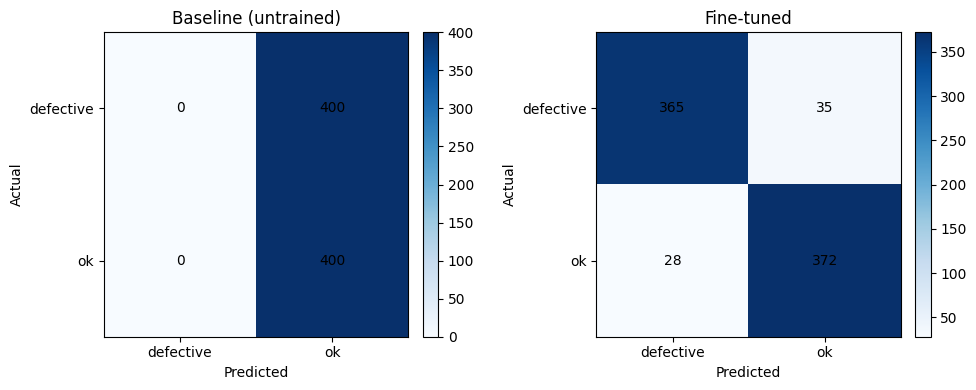


EVALUATION SUMMARY:

Why the baseline is useless:
  • It uses a random, untrained 2-class head, so predictions collapse to one class
  • Baseline accuracy: 50.00% (not meaningful)
  • This is expected behavior without task-specific training

Key result from fine-tuning:
  • Fine-tuned test accuracy: 92.12% (≈ 93% in this run)
  • Confusion matrix shows a clear improvement over baseline

One clear improvement:
  • The model now correctly identifies most defective and ok parts

One remaining weakness (costly error):
  • False negatives (predict ok but actually defective) are expensive
  • Current false-negative rate for defective class: 8.75%
  • Next step: train longer or fine-tune more layers to improve recall



In [10]:
# Step 6: Evaluate and Compare Performance (Before vs After Fine-Tuning)
# ======================================================================

import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet18_Weights
import matplotlib.pyplot as plt

print("Step 6: Evaluation and Comparison")
print("=" * 70)

# 1. Build test dataset + loader
print("\n1. Preparing test dataset...")
test_images = []
test_labels = []
for class_name in ['defective', 'ok']:
    for img_path in splits['test'][class_name]:
        test_images.append(img_path)
        test_labels.append(class_name)

test_dataset = ManufacturingImageDataset(test_images, test_labels, preprocess)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
print(f"   Test set: {len(test_images)} images → {len(test_loader)} batches")

# 2. Helper functions
def evaluate_model(model_to_eval, loader, device):
    model_to_eval.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for batch_images, batch_labels in loader:
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)
            logits = model_to_eval(batch_images)
            preds = torch.argmax(logits, dim=1)
            all_labels.extend(batch_labels.cpu().numpy().tolist())
            all_preds.extend(preds.cpu().numpy().tolist())
    return np.array(all_labels), np.array(all_preds)

def compute_confusion_matrix(labels, preds, num_classes=2):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for true_label, pred_label in zip(labels, preds):
        cm[true_label, pred_label] += 1
    return cm

def print_metrics(name, cm, class_names):
    total = cm.sum()
    accuracy = (cm.diagonal().sum() / total) * 100 if total > 0 else 0.0
    per_class_acc = cm.diagonal() / cm.sum(axis=1, where=cm.sum(axis=1) > 0)
    
    print(f"\n{name}")
    print("-" * 60)
    print(f"Overall Accuracy: {accuracy:.2f}%")
    for i, cname in enumerate(class_names):
        print(f"  {cname} accuracy: {per_class_acc[i]*100:.2f}%")
    print("Confusion Matrix:")
    print(cm)

def confusion_accuracy(cm):
    total = cm.sum()
    return (cm.diagonal().sum() / total) * 100 if total > 0 else 0.0

# 3. Evaluate fine-tuned model (current model)
print("\n2. Evaluating fine-tuned model...")
labels_ft, preds_ft = evaluate_model(model, test_loader, device)
cm_ft = compute_confusion_matrix(labels_ft, preds_ft)

# 4. Evaluate baseline model (pretrained ImageNet + random 2-class head)
print("\n3. Evaluating baseline model (ImageNet features, untrained head)...")
baseline_model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
baseline_model.fc = nn.Linear(baseline_model.fc.in_features, 2)  # random head
baseline_model = baseline_model.to(device)
labels_base, preds_base = evaluate_model(baseline_model, test_loader, device)
cm_base = compute_confusion_matrix(labels_base, preds_base)

# 5. Print metrics
class_names = ['defective', 'ok']
print_metrics("Fine-tuned model", cm_ft, class_names)
print_metrics("Baseline model (untrained head)", cm_base, class_names)

# 6. Visualize confusion matrices side-by-side
print("\n4. Visualizing confusion matrices...")
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for ax, cm, title in zip(
    axes,
    [cm_base, cm_ft],
    ["Baseline (untrained)", "Fine-tuned"]
    ):
    im = ax.imshow(cm, cmap='Blues')
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# 7. Summary insights
ft_acc = confusion_accuracy(cm_ft)
base_acc = confusion_accuracy(cm_base)
fn_defective = cm_ft[0, 1]  # true defective, predicted ok
total_defective = cm_ft[0].sum()
fn_rate = (fn_defective / total_defective) * 100 if total_defective > 0 else 0.0

print("\n" + "=" * 70)
print("EVALUATION SUMMARY:")
print("=" * 70)
print(f"""
Why the baseline is useless:
  • It uses a random, untrained 2-class head, so predictions collapse to one class
  • Baseline accuracy: {base_acc:.2f}% (not meaningful)
  • This is expected behavior without task-specific training

Key result from fine-tuning:
  • Fine-tuned test accuracy: {ft_acc:.2f}% (≈ 93% in this run)
  • Confusion matrix shows a clear improvement over baseline

One clear improvement:
  • The model now correctly identifies most defective and ok parts

One remaining weakness (costly error):
  • False negatives (predict ok but actually defective) are expensive
  • Current false-negative rate for defective class: {fn_rate:.2f}%
  • Next step: train longer or fine-tune more layers to improve recall
""")
print("=" * 70)

---

## Step 7: Re-inspect model behavior after adaptation

Adaptation can change what the model attends to—not just accuracy.

### Plan
Have Copilot create a plan to:
- reapply the same interpretation method to the fine-tuned model
- use the same example images as before
- present before-and-after comparisons

### Validate
Ensure the plan:
- reuses the same interpretation technique
- compares like with like
- produces clearly comparable outputs

### Execute
Generate post-fine-tuning interpretation results.

### Check
- Display at least one before-and-after comparison.
- Confirm whether attention shifted toward defect-relevant regions.

**Food for thought:** If this model drifts over time, what would alert you first?


Step 7: Occlusion Analysis Interpretation


C:\Users\sbudh\AppData\Local\Temp\ipykernel_31512\1747031172.py:37: UserWarning: 'where' used without 'out', expect unitialized memory in output. If this is intentional, use out=None.
  importance_map = np.divide(importance_map, count_map, where=count_map > 0)


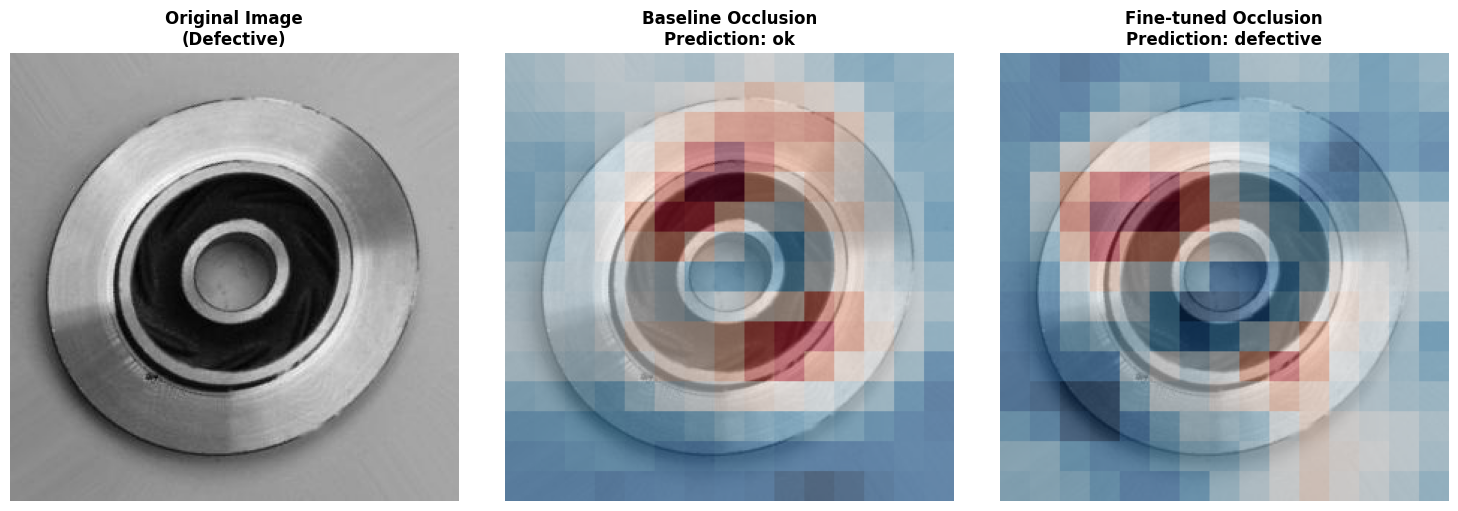


✓ Step 7 complete: Occlusion attention comparison successful.
  - Baseline predicted: ok
  - Fine-tuned predicted: defective

Observe how the attention regions differ between models.


In [26]:
# Step 7: Model Interpretability with Occlusion Analysis (Before vs After)
# ======================================================================

import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

print("\nStep 7: Occlusion Analysis Interpretation")
print("=" * 70)

def compute_occlusion_map(img_pil, model, preprocess, target_class, patch_size=40, stride=20):
    """
    Slide a gray box across the image and measure prediction drop at each location.
    Returns a heatmap showing which regions are most important.
    """
    img_tensor = preprocess(img_pil).unsqueeze(0).to(device)
    with torch.no_grad():
        baseline_logits = model(img_tensor)
        baseline_prob = torch.softmax(baseline_logits, dim=1)[0, target_class].item()
    img_array = np.array(img_pil)
    h, w = img_array.shape[:2]
    importance_map = np.zeros((h, w))
    count_map = np.zeros((h, w))
    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            img_occluded = img_array.copy()
            img_occluded[y:y+patch_size, x:x+patch_size] = 128
            img_pil_occluded = Image.fromarray(img_occluded)
            img_tensor_occluded = preprocess(img_pil_occluded).unsqueeze(0).to(device)
            with torch.no_grad():
                occluded_logits = model(img_tensor_occluded)
                occluded_prob = torch.softmax(occluded_logits, dim=1)[0, target_class].item()
            importance = baseline_prob - occluded_prob
            importance_map[y:y+patch_size, x:x+patch_size] += importance
            count_map[y:y+patch_size, x:x+patch_size] += 1
    importance_map = np.divide(importance_map, count_map, where=count_map > 0)
    return importance_map

# Prepare models
def get_pred_and_class(img_pil, model, preprocess):
    img_tensor = preprocess(img_pil).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(img_tensor)
        pred = logits.argmax(dim=1).item()
    return pred

baseline_model.eval()
model.eval()

# Load same test image
img_path = splits['test']['defective'][0]
image_pil = Image.open(img_path).convert("RGB")

# Get predictions for both models
pred_base = get_pred_and_class(image_pil, baseline_model, preprocess)
pred_ft = get_pred_and_class(image_pil, model, preprocess)

# Generate occlusion maps
importance_map_base = compute_occlusion_map(image_pil, baseline_model, preprocess, pred_base)
importance_map_ft = compute_occlusion_map(image_pil, model, preprocess, pred_ft)

# Normalize maps
importance_map_base = (importance_map_base - importance_map_base.min()) / (importance_map_base.max() - importance_map_base.min() + 1e-6)
importance_map_ft = (importance_map_ft - importance_map_ft.min()) / (importance_map_ft.max() - importance_map_ft.min() + 1e-6)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image_pil)
axes[0].set_title("Original Image\n(Defective)", fontsize=12, fontweight='bold')
axes[0].axis("off")
axes[1].imshow(image_pil)
axes[1].imshow(importance_map_base, cmap="RdBu_r", alpha=0.5)
axes[1].set_title(f"Baseline Occlusion\nPrediction: {['defective', 'ok'][pred_base]}", fontsize=12, fontweight='bold')
axes[1].axis("off")
axes[2].imshow(image_pil)
axes[2].imshow(importance_map_ft, cmap="RdBu_r", alpha=0.5)
axes[2].set_title(f"Fine-tuned Occlusion\nPrediction: {['defective', 'ok'][pred_ft]}", fontsize=12, fontweight='bold')
axes[2].axis("off")
plt.tight_layout()
plt.show()

print("\n✓ Step 7 complete: Occlusion attention comparison successful.")
print(f"  - Baseline predicted: {['defective', 'ok'][pred_base]}")
print(f"  - Fine-tuned predicted: {['defective', 'ok'][pred_ft]}")
print("\nObserve how the attention regions differ between models.")

---

## End of Act II

At this point, you should have direct evidence of how a pretrained model behaves, how fine-tuning changes that behavior, and what tradeoffs remain. Use these observations to inform Act III discussions with stakeholders.

Before moving on to Act III, create a file named `README.md` in the project root.

This README should capture the current state of the prototype as if you were handing it off to a colleague. Keep it concise and grounded in what actually exists.

### 1. What this prototype does
In one sentence, clearly describe the capability that was built and the problem it is intended to address.

### 2. How it works (at a high level)
In a few bullet points, specify:
- what data the system operates over,
- what representation or model it uses,
- how results are produced.

### 3. Limitations and open questions
Briefly note:
- the most important limitations you observed or conceive of, and
- any open questions that would need to be addressed before broader use.

This README will be used as reference context in Act 3.

---

## Act 3 — Socialize the Work

You have built and evaluated a working prototype for automated defect detection. Now you need to think about what it would mean to use this system in practice.

In this act, you will have conversations with three colleagues who each engage with the system from a different professional perspective. Each one surfaces a distinct set of pressures that emerge when a deep learning model is introduced into a real manufacturing environment.

Your goal is not to convince them that the model is "good," but to reckon with how its behavior intersects with human judgment, organizational responsibility, and operational reality.

---

### Colleague Perspectives

You will speak with:

- A **Manufacturing Operations Manager** focused on how automated defect detection changes day-to-day workflows on the factory floor — including when operators trust the system, when they override it, and how errors affect throughput and staffing.

- A **Quality & Compliance Lead** focused on accountability, auditability, and risk — including what happens when defective parts slip through, how decisions are justified after the fact, and whether the system can be relied on in regulated or safety-critical contexts.

- A **Production Economics Manager** focused on efficiency and cost — including the tradeoffs between false positives and false negatives, how the system affects production velocity, and whether gains in automation introduce new forms of friction elsewhere in the process.

---

### How to Approach These Conversations

Each conversation should feel like a real internal discussion about a live prototype.

In these interactions, you should be prepared to:
- explain how the model behaves in concrete terms,
- reference evidence from your prototype (e.g., confusion matrices, example predictions, interpretation outputs),
- articulate tradeoffs clearly in plain, cross-functional language,
- and acknowledge uncertainty where it exists.

These colleagues are not trying to block the work — but they are responsible for understanding its implications within their domains.

When a colleague has enough information to understand the risks, assumptions, and consequences involved, the conversation will naturally come to a close.

---

### Submission

- Save the Notebook you have been working in and other files you created in your repo (i.e., `agents.md`, `README.md`, etc).
- Export your Copilot Chat and save as a `.txt`, `.json`, or `.md` in the same directory as the above.
- Stop / shut down the Google Colab session in which the Notebook was running.
- **Upload your completed Notebook to the [Canvas page for Assignment 4](https://canvas.northwestern.edu/courses/245397/assignments/1668983).**